<a href="https://colab.research.google.com/github/fbeilstein/topological_data_analysis/blob/master/lecture_15_topological_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[A Topology Layer for Machine Learning](https://arxiv.org/pdf/1905.12200)

In [24]:
!git clone https://github.com/bruel-gabrielsson/TopologyLayer.git
!mv ./TopologyLayer/setup.py ./temp.py
!cat temp.py | sed 's/-std=c++14/-std=c++17/g' > ./TopologyLayer/setup.py
!rm temp.py
!cd TopologyLayer/ && python setup.py install --record files.txt > log.txt 2>&1

import sys
sys.path.append('/usr/local/lib/python3.11/dist-packages/topologylayer-0.0.0-py3.11-linux-x86_64.egg')

Cloning into 'TopologyLayer'...
remote: Enumerating objects: 1085, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1085 (delta 4), reused 0 (delta 0), pack-reused 1071 (from 1)
Receiving objects: 100% (1085/1085), 5.78 MiB | 26.30 MiB/s, done.
Resolving deltas: 100% (668/668), done.


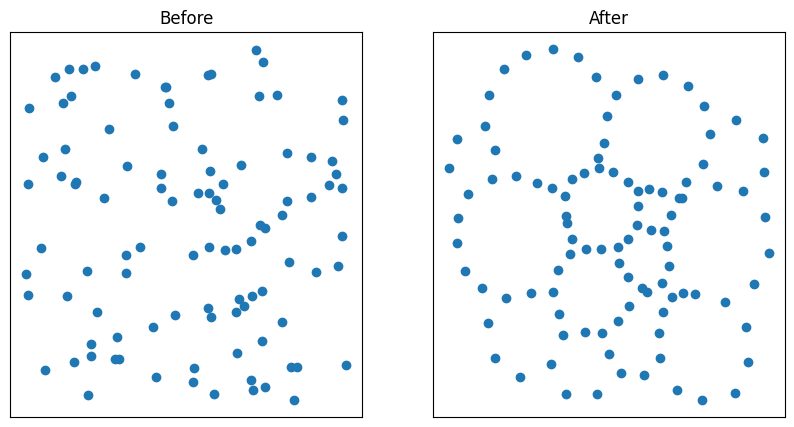

In [21]:
# Example from README
from topologylayer.nn import AlphaLayer, BarcodePolyFeature
import torch, numpy as np, matplotlib.pyplot as plt

# random pointcloud
np.random.seed(0)
data = np.random.rand(100, 2)

# optimization to increase size of holes
layer = AlphaLayer(maxdim=1)
x = torch.autograd.Variable(torch.tensor(data).type(torch.float), requires_grad=True)
f1 = BarcodePolyFeature(1,2,0)
optimizer = torch.optim.Adam([x], lr=1e-2)
for i in range(100):
  optimizer.zero_grad()
  loss = -f1(layer(x))
  loss.backward()
  optimizer.step()

# save figure
y = x.detach().numpy()
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(data[:,0], data[:,1])
ax[0].set_title("Before")
ax[1].scatter(y[:,0], y[:,1])
ax[1].set_title("After")
for i in range(2):
  ax[i].set_yticklabels([])
  ax[i].set_xticklabels([])
  ax[i].tick_params(bottom=False, left=False)
plt.draw()
plt.show()

0 222.20681762695312 8.688663677425268e-11
10 132.74374389648438 1.677051067352295
20 93.05523681640625 1.8445172309875488
30 69.28870391845703 1.6894460916519165
40 54.2552490234375 1.5087392330169678
50 43.221290588378906 1.3658647537231445
60 34.79819869995117 1.2580674886703491
70 28.729524612426758 1.1223254203796387
80 23.645917892456055 1.0564638376235962
90 19.83224868774414 0.9713330268859863
100 16.700870513916016 0.8677304983139038
110 13.94662857055664 0.7884786128997803
120 11.70433235168457 0.709388256072998
130 9.847186088562012 0.6474424004554749
140 8.407029151916504 0.5912266969680786
150 7.13594913482666 0.5403004288673401
160 5.968109130859375 0.48355862498283386
170 4.959262371063232 0.44059237837791443
180 4.096020698547363 0.4030147194862366
190 3.5143778324127197 0.36154255270957947
200 3.144484043121338 0.31908971071243286
210 2.764787435531616 0.288362056016922
220 2.53497052192688 0.26319363713264465
230 2.3201942443847656 0.24043111503124237
240 2.1487057209

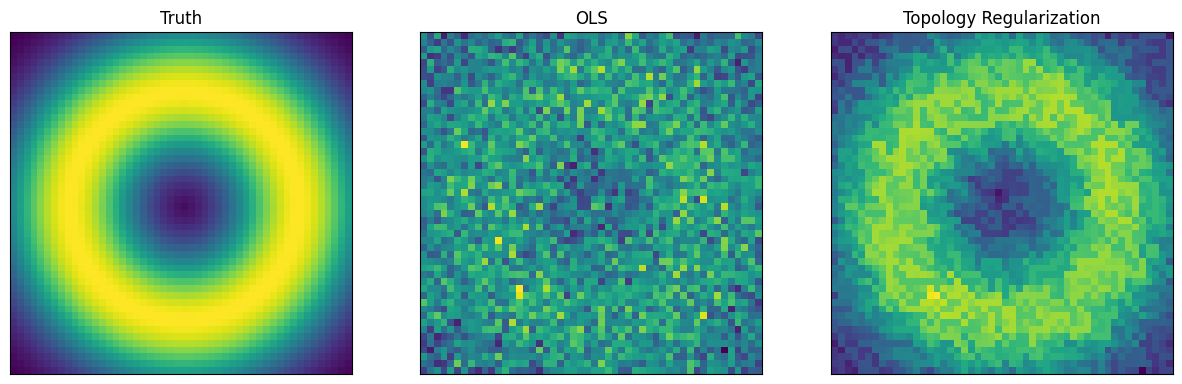

In [25]:
from __future__ import print_function
import torch, torch.nn as nn, numpy as np, matplotlib.pyplot as plt
from topologylayer.nn import LevelSetLayer2D, SumBarcodeLengths, PartialSumBarcodeLengths

n = 50
def circlefn(i, j, n):
  r = np.sqrt((i - n/2.)**2 + (j - n/2.)**2)
  return np.exp(-(r - n/3.)**2/(n*2))


def gen_circle(n):
  beta = np.empty((n,n))
  for i in range(n):
    for j in range(n):
      beta[i,j] = circlefn(i,j,n)
  return beta

beta = gen_circle(n)

m = 1500
X = np.random.randn(m, n**2)
y = X.dot(beta.flatten()) + 0.05*np.random.randn(m)
beta_ols = (np.linalg.lstsq(X, y, rcond=None)[0]).reshape(n,n)

class TopLoss(nn.Module):
  def __init__(self, size):
    super(TopLoss, self).__init__()
    self.pdfn = LevelSetLayer2D(size=size,  sublevel=False)
    self.topfn = PartialSumBarcodeLengths(dim=1, skip=1)
    self.topfn2 = SumBarcodeLengths(dim=0)

  def forward(self, beta):
    dgminfo = self.pdfn(beta)
    return self.topfn(dgminfo) + self.topfn2(dgminfo)

tloss = TopLoss((50,50)) # topology penalty
dloss = nn.MSELoss() # data loss

beta_t = torch.autograd.Variable(torch.tensor(beta_ols).type(torch.float), requires_grad=True)
X_t = torch.tensor(X, dtype=torch.float, requires_grad=False)
y_t = torch.tensor(y, dtype=torch.float, requires_grad=False)
optimizer = torch.optim.Adam([beta_t], lr=1e-2)
for i in range(500):
  optimizer.zero_grad()
  tlossi = tloss(beta_t)
  dlossi = dloss(y_t, torch.matmul(X_t, beta_t.view(-1)))
  loss = 0.1*tlossi + dlossi
  loss.backward()
  optimizer.step()
  if (i % 10 == 0):
    print(i, tlossi.item(), dlossi.item())


# save figure
beta_est = beta_t.detach().numpy()
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(beta)
ax[0].set_title("Truth")
ax[1].imshow(beta_ols)
ax[1].set_title("OLS")
ax[2].imshow(beta_est)
ax[2].set_title("Topology Regularization")
for i in range(3):
  ax[i].set_yticklabels([])
  ax[i].set_xticklabels([])
  ax[i].tick_params(bottom=False, left=False)
plt.draw()
plt.show()